# Data exploration

## Packages import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#%pip install squarify
import squarify
#%pip install plotly
from plotly import tools
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%matplotlib inline
#Setting seed
np.random.seed(123)

In [2]:
#Reading data
df = pd.read_csv("bank_marketing_weka_dataset.csv")

In [3]:
#Checking data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
age          4521 non-null int64
job          4521 non-null object
marital      4521 non-null object
education    4521 non-null object
default      4521 non-null object
balance      4521 non-null int64
housing      4521 non-null object
loan         4521 non-null object
contact      4521 non-null object
day          4521 non-null int64
month        4521 non-null object
duration     4521 non-null float64
campaign     4521 non-null int64
pdays        4521 non-null float64
previous     4521 non-null int64
poutcome     4521 non-null object
y            4521 non-null object
dtypes: float64(2), int64(5), object(10)
memory usage: 600.6+ KB


No missing values. Variables are both categorical strings and
continuous numerical.

In [4]:
#Basic information
df.describe()

age       balance          day     duration     campaign  \
count  4521.000000   4521.000000  4521.000000  4521.000000  4521.000000   
mean     41.170095   1422.657819    15.915284   263.961292     2.793630   
std      10.576211   3009.638142     8.247667   259.856633     3.109807   
min      19.000000  -3313.000000     1.000000     4.000000     1.000000   
25%      33.000000     69.000000     9.000000   104.000000     1.000000   
50%      39.000000    444.000000    16.000000   185.000000     2.000000   
75%      49.000000   1480.000000    21.000000   329.000000     3.000000   
max      87.000000  71188.000000    31.000000  3025.000000    50.000000   

             pdays     previous  
count  4521.000000  4521.000000  
mean     39.766645     0.542579  
std     100.121124     1.693562  
min      -1.000000     0.000000  
25%      -1.000000     0.000000  
50%      -1.000000     0.000000  
75%      -1.000000     0.000000  
max     871.000000    25.000000

## Continuous variables

In [5]:
# Funkcja to draw histogram and boxplot
def plot_var(col, variable):
    plot = sns.distplot(col, hist = True, kde = True)
    plot.set_title("Variable distribution: " + variable)
    
    fig, ax = plt.subplots()
    ax.set_title("Variable: " + variable)
    ax.boxplot(col, vert = False)

## Age

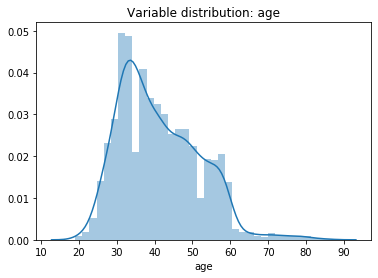

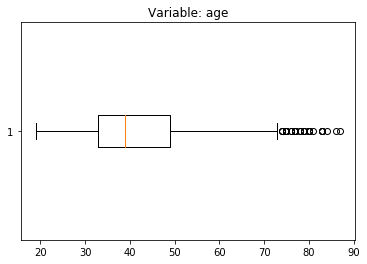

In [6]:
plot_var(df.age, "age")

Skewed distribution, most clients in middle age (30-40). Few clients older than 60 years.

## Balance: Average yearly balance in Euro

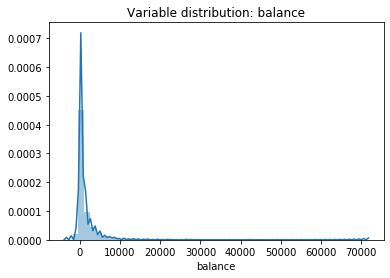

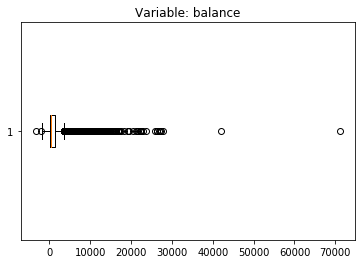

In [7]:
plot_var(df.balance, "balance")

Very heavy tail of distribution. Let's examine the distribution of balances up to 10,000 euros.

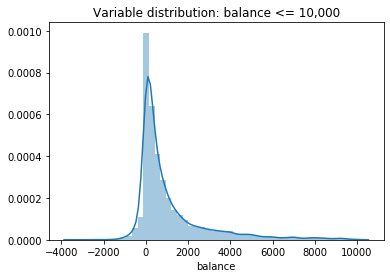

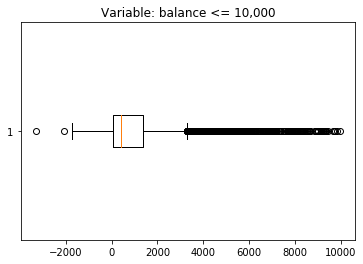

In [8]:
plot_var(df.balance[df.balance <= 10000], "balance <= 10,000")

In [9]:
df_under_10000 = df[df.balance <= 10000]
#Percentage of customers with balance below 10,000 euros
per_under_10000 = len(df_under_10000.index)/len(df.index)
print(per_under_10000*100)

97.96505197965053


Customers with avareage yearly balance under 10,000 euro are almost 98% of whole group.

## Duration: Last contact duration [seconds]

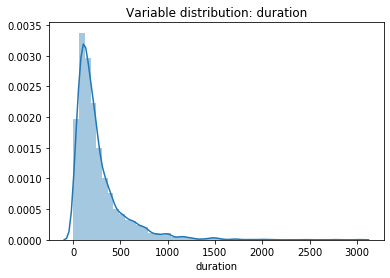

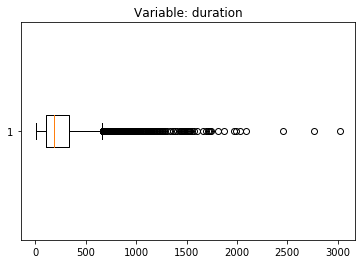

In [10]:
plot_var(df.duration, "duration")

Skewed distribution with tail of last contacts longer than 500s.

## Campaign: Number of contacts made

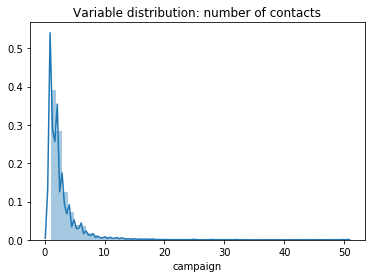

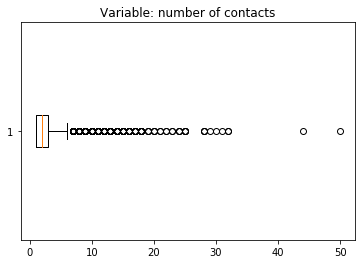

In [11]:
plot_var(df.campaign, "number of contacts")

Again skewed distribution, most clients have less than 10 contacts.

## Pdays: Number of days passed since client was last contacted from a previous campaign

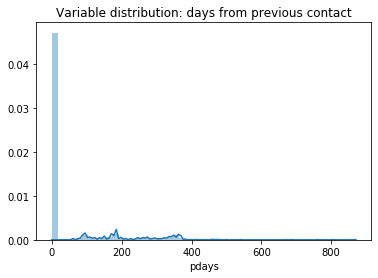

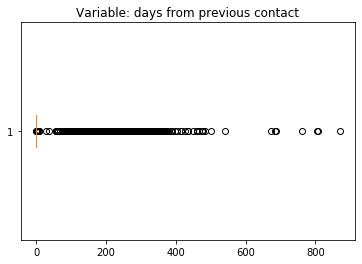

In [12]:
# -1 value means client was not contacted
plot_var(df.pdays, "days from previous contact")

Distribution for clients contacted at least once.

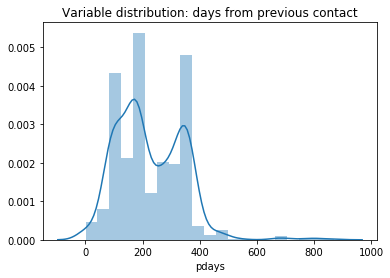

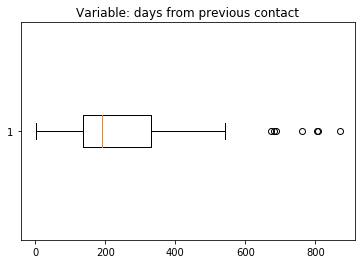

In [13]:
contacted_clients = df[df.pdays >= 0]
plot_var(contacted_clients.pdays, "days from previous contact")

Distribution seems to be bimodal, let's check it better after throwing out outliers.

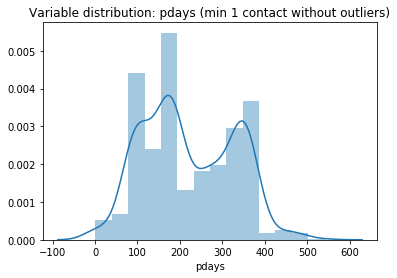

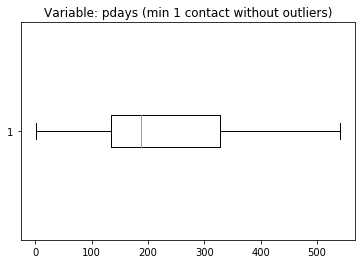

In [14]:
plot_var(contacted_clients.pdays[contacted_clients.pdays<=600],"pdays (min 1 contact without outliers)")

For customers contacted at least once and without group of these who have not been contacted for over 600 days distribution of pday variable is definietly bimodal.

## Previous: Number of contacts performed before this campaign and for this client

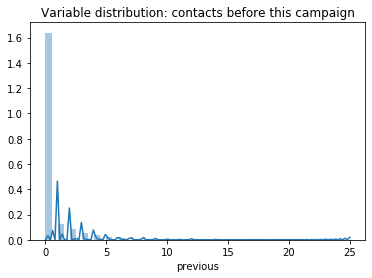

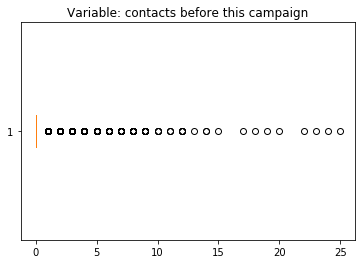

In [15]:
plot_var(df.previous, "contacts before this campaign")

In [16]:
contacted_before = df[df.previous>0]
per_contacted_before = len(contacted_before.index)/len(df.index)
print(per_contacted_before*100)

18.049104180491042


Only 18% of customers were contacted in previous campaigns. That explains mean value for this variable and its distribution.

# Relationships between continuous variables

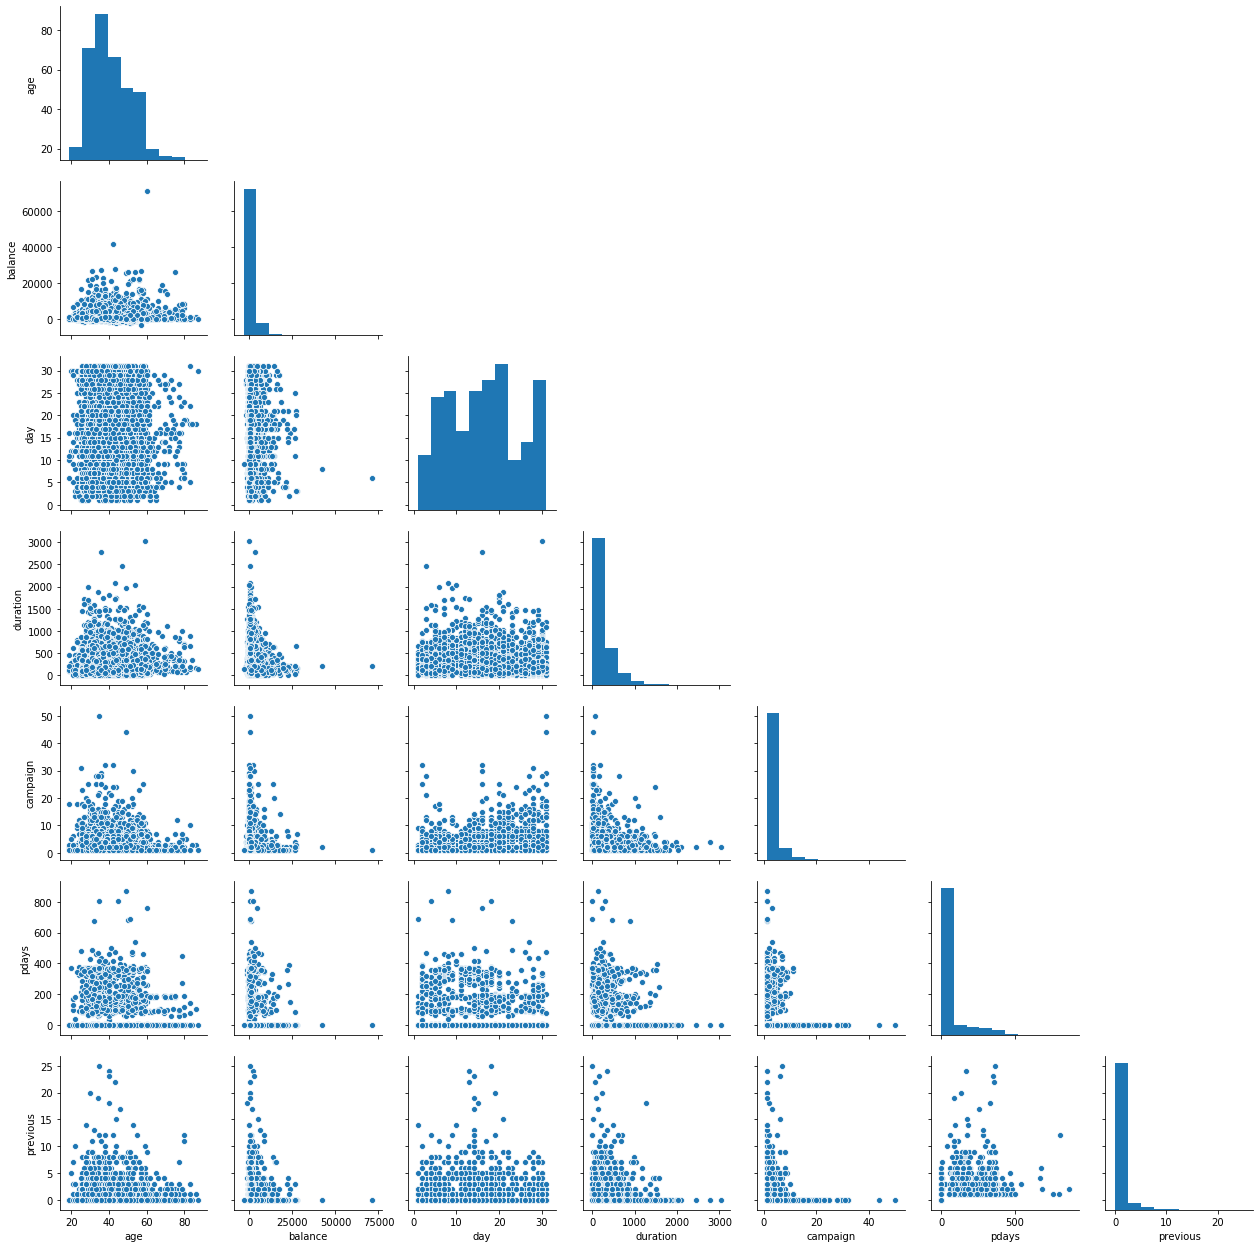

In [41]:
# Separate both dataframes into 
numeric_df = df.select_dtypes(exclude="object")
# categorical_df = df.select_dtypes(include="object")

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
g = sns.pairplot(numeric_df)
g.map_upper(hide_current_axis)

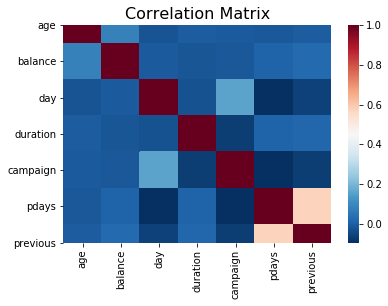

In [17]:
corr_numeric = numeric_df.corr()


sns.heatmap(corr_numeric, cbar=True, cmap="RdBu_r")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

We cannot observe strong correlations but there are few dependencies.

### Balance and last contact duration

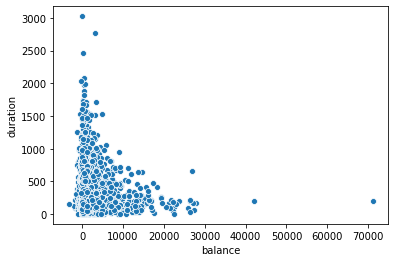

In [49]:
sns.scatterplot(y = 'duration', x = 'balance', data = df)

People with higher balance (over about 10,000) don't have long contacts, which could mean that presented
offer is not interesting for them if they don't want to take time for longer contact.

### Balance and contacts in campaign

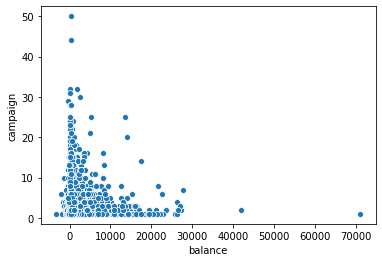

In [78]:
sns.scatterplot(x = 'balance', y = 'campaign', data = df)


Clients who are contacted in this campaign more frequently are from group of people with lower balance.  

## Analysis of categorical variables

In [18]:
df.select_dtypes(include='object').columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'y'],
      dtype='object')

In [19]:
def plot_var(col, variable,rotation=False,data=df):
    
    plt.figure(figsize=(10,6))
    plot = sns.countplot(x=col, data=data, palette="muted")
    if rotation:
        plot.set_xticklabels(plot.get_xticklabels(), rotation=30, ha="right")
    plot.set_title("Variable distribution: " + variable)
    plt.tight_layout()

 

def plot_var_vs_target(col,variable,rotation=False,data=df):
    x,y = col, 'y'
    data = data.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()
    plot = sns.catplot(data = data, x=x,y='percent',hue=y,kind='bar',height=4, aspect=2,legend_out=False)
    if rotation:
        plot.set_xticklabels(rotation=30)
    plot.fig.suptitle(f'{variable} vs target' ) 
    plt.tight_layout()

def plot_both(column,rotation=False,data=df):
    plot_var(column,column.capitalize(),rotation,data=data)
    plot_var_vs_target(column,column.capitalize(),rotation,data=data)
  

In [20]:
def job_plot():
    '''Quite interesting and interactive presentation of job distribution in dataset which I found on the Internet '''
    x = 0
    y = 0
    width = 100
    height = 100

    job_names = df['job'].value_counts().index
    values = df['job'].value_counts().tolist()

    normed = squarify.normalize_sizes(values, width, height)
    rects = squarify.squarify(normed, x, y, width, height)

    colors = ['rgb(200, 255, 144)','rgb(135, 206, 235)',
            'rgb(235, 164, 135)','rgb(220, 208, 255)',
            'rgb(253, 253, 150)','rgb(255, 127, 80)', 
            'rgb(218, 156, 133)', 'rgb(245, 92, 76)',
            'rgb(252,64,68)', 'rgb(154,123,91)']

    shapes = []
    annotations = []
    counter = 0

    for r in rects:
        shapes.append(
            dict(
                type = 'rect',
                x0 = r['x'],
                y0 = r['y'],
                x1 = r['x'] + r['dx'],
                y1 = r['y'] + r['dy'],
                line = dict(width=2),
                fillcolor = colors[counter]
            )
        )
        annotations.append(
            dict(
                x = r['x']+(r['dx']/2),
                y = r['y']+(r['dy']/2),
                text = values[counter],
                showarrow = False
            )
        )
        counter = counter + 1
        if counter >= len(colors):
            counter = 0
        
    # For hover text
    trace0 = go.Scatter(
        x = [ r['x']+(r['dx']/2) for r in rects],
        y = [ r['y']+(r['dy']/2) for r in rects],
        text = [ str(v) for v in job_names],
        mode='text',
    )

    layout = dict(
        title='Number of Occupations <br> <i>(From our Sample Population)</i>',
        height=700, 
        width=700,
        xaxis=dict(showgrid=False,zeroline=False),
        yaxis=dict(showgrid=False,zeroline=False),
        shapes=shapes,
        annotations=annotations,
        hovermode='closest'
    )

    # With hovertext
    figure = dict(data=[trace0], layout=layout)

    iplot(figure, filename='squarify-treemap')

## Job

In [21]:
job_plot()

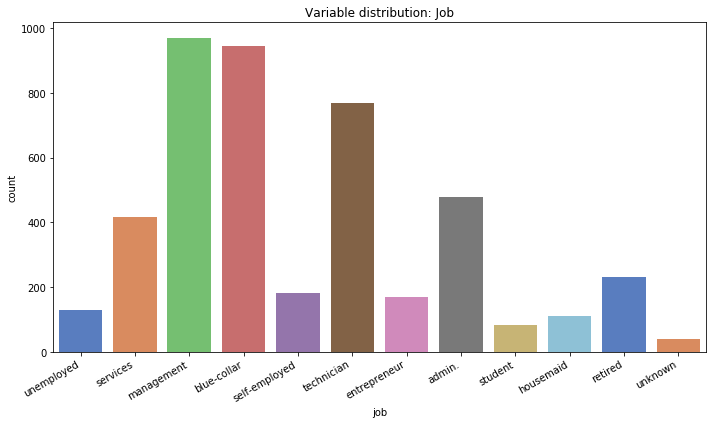

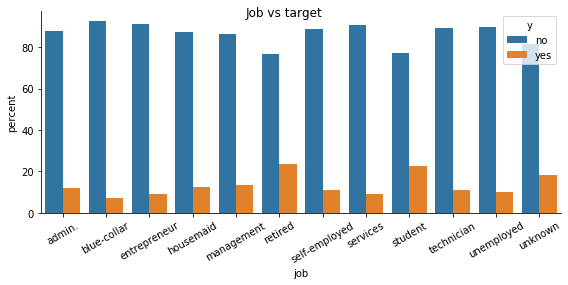

In [22]:
plot_both('job',rotation=True)


The biggest amount of people in out dataset belong to managment or blue-collar group. Also the biggest chances of subscription seems to be in a retired and student groups which is kinda interesting.

## Marital

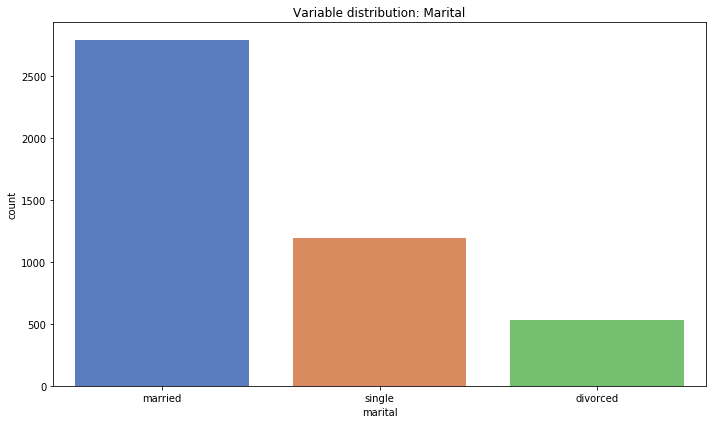

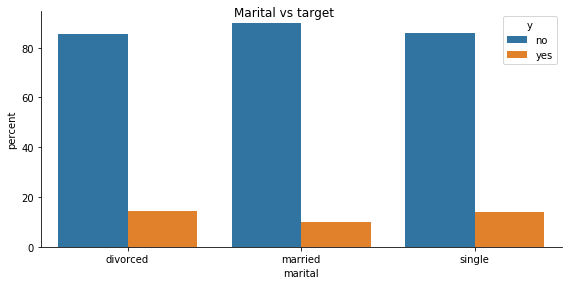

In [23]:
plot_both('marital')

In [24]:
(len(df[df.marital=='married'])/len(df.marital))*100

61.86684361866843

Married people are almost 62% of our data, but there are no visible diffrences in terms of our target amongst groups.

## Education

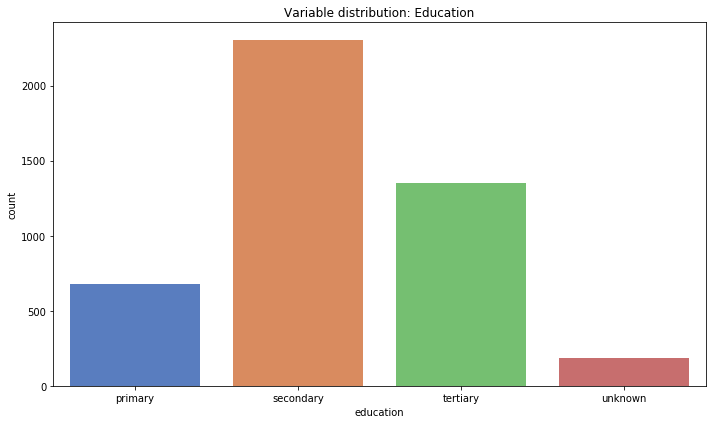

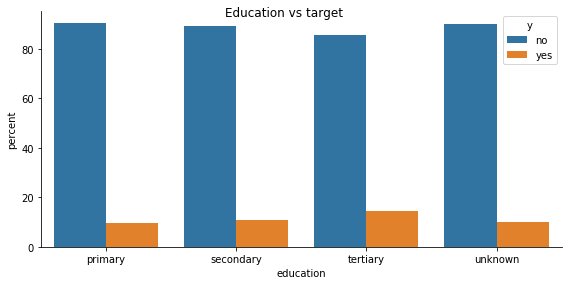

In [25]:
plot_both('education')

A bit higher amount of subscriptions among people with tertiary education may be correlated with a bigger amount of subscriptions among students what we have seen earlier.

## Loans

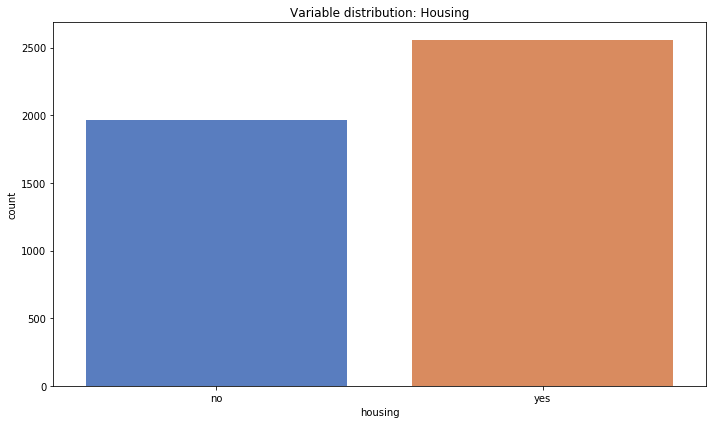

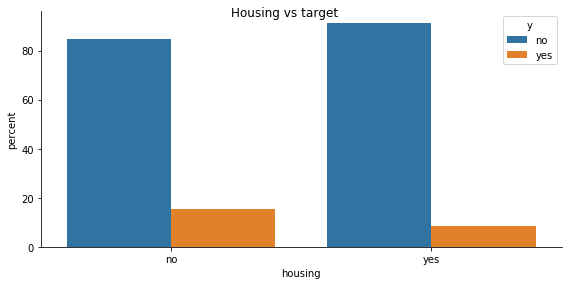

In [26]:
plot_both('housing')

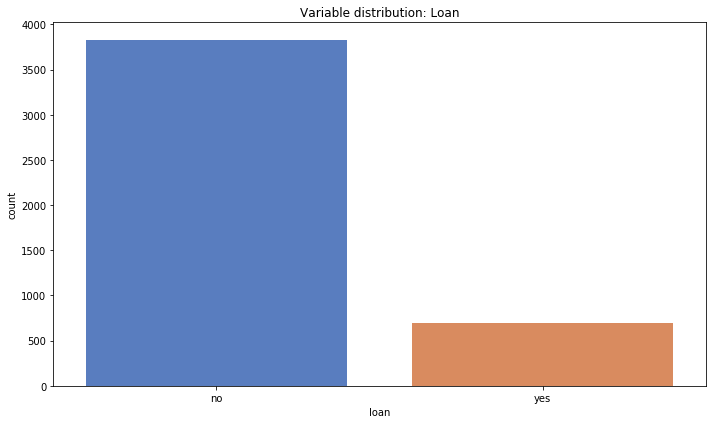

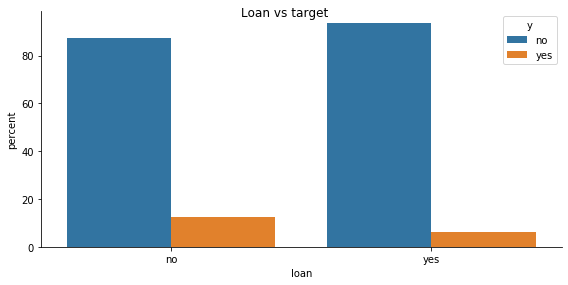

In [27]:
plot_both('loan')

Majority of people have house loan but doesnt have a personal loan. However in both cases the bigger subscription rate is among people who do not have loans. It is certainly worth checking it further.

## Contact

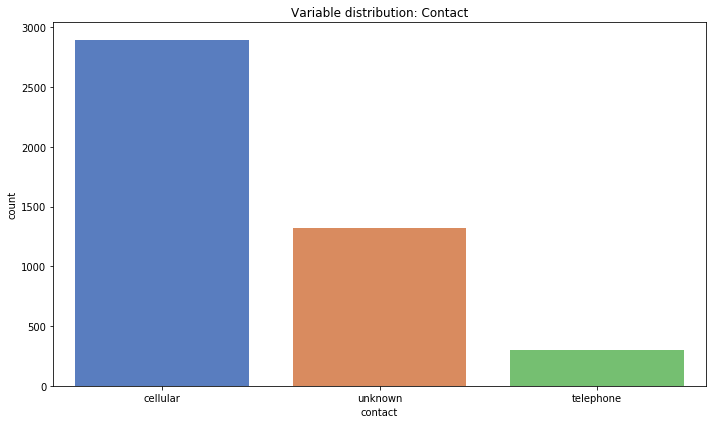

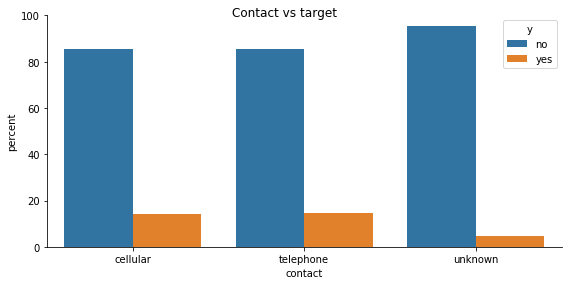

In [28]:
plot_both('contact')

Most of the people have been contaced through the ceullar but it does not seem to have any impact on out target.

## Poutcome (previous outcome)

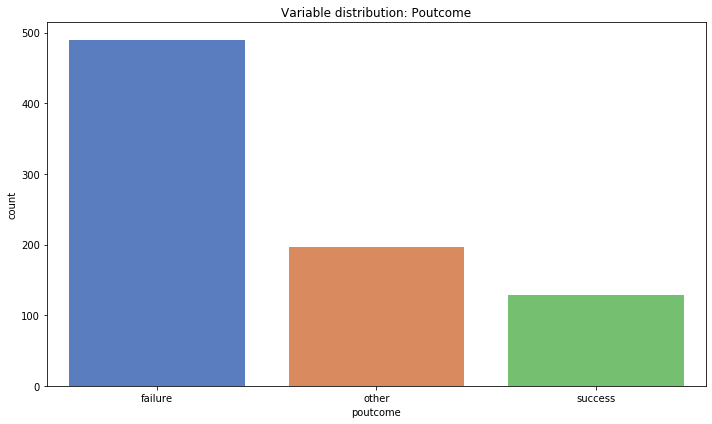

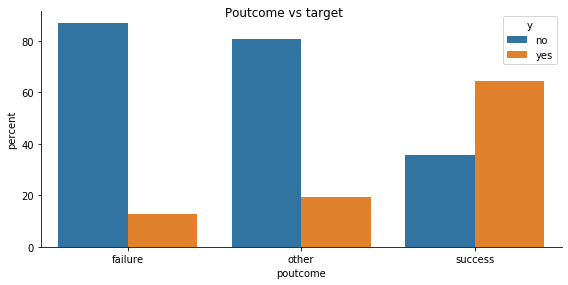

In [29]:
data_help = df[df.poutcome !='unknown']
plot_both('poutcome',data=data_help)

We decided for now to get rid of unknown for that plot, becuase it does not tell to much, but we can se that there is correlation beetwen previous succes in therms of our target and the succes that we want to predict.

# Relationships between variables

## Age among different jobs

In [30]:
def boxes(x,y,hue=None,rotation=False,data=df):
    plt.figure(figsize=(10,6))
    plot = sns.boxplot(x=x,y=y,data=data,palette='muted')
    if rotation:
        plt.setp(plot.get_xticklabels(), rotation=30)
    plt.tight_layout()
    plt.title(f'{x} vs {y}')

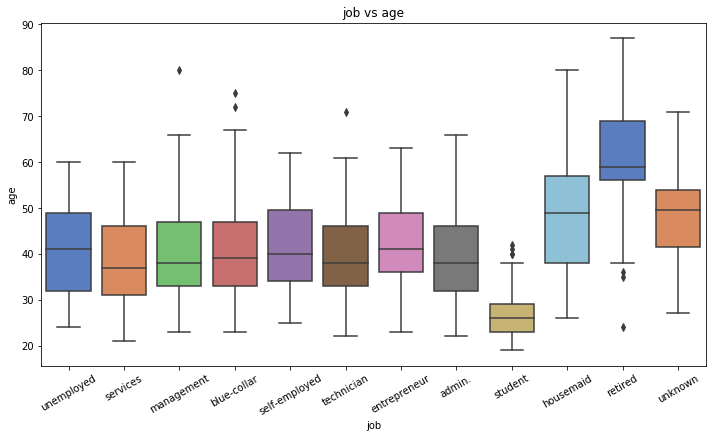

In [31]:
boxes('job','age',rotation=True)


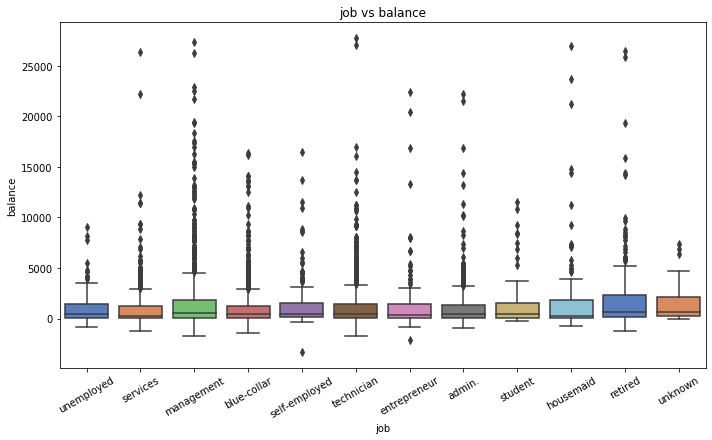

In [32]:
data1 = df[df.balance<30000]
boxes('job','balance',rotation=True,data=data1)
#Droped outliers for purpose of the plot in order to better visualize distribution of variables

Balance and age seem to be almost equally distributed among job groups.

## Martial/education impact

In [33]:
df['marital/education'] = df['marital'] + "/" + df['education']

Text(0.5, 1.0, 'Median Balance by Educational/Marital Group')

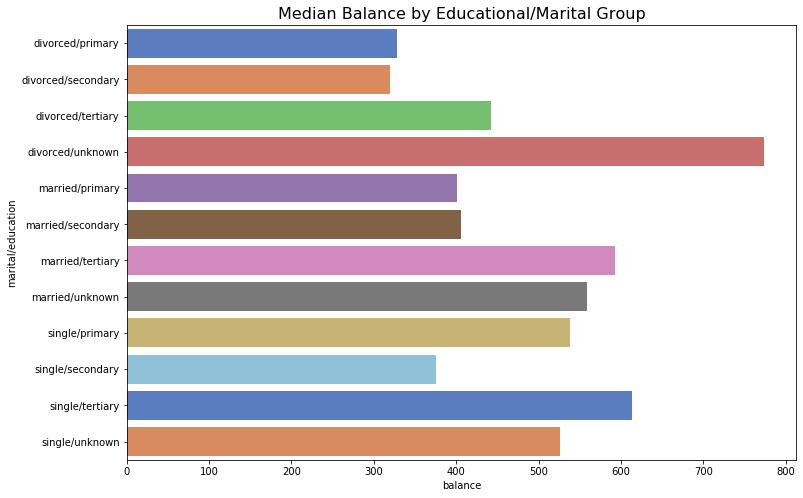

In [34]:
education_groups = df.groupby(['marital/education'], as_index=False)['balance'].median()
fig = plt.figure(figsize=(12,8))
sns.barplot(x="balance", y="marital/education", data=education_groups,
            label="Total", palette="muted")
plt.title('Median Balance by Educational/Marital Group', fontsize=16)

There is visible impact of both marital status and education on balance.